In [1]:
import os
import json
import cv2
import numpy as np
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import random

In [5]:
def generate_training_data(images_dir, annotations, roi_size=64, negative_samples_per_positive=1):
    train_data = []
    
    for image_file, bbox in annotations.items():
        # Check if the bounding box is None (missing annotation)
        if bbox is None:
            continue
        
        image_path = os.path.join(images_dir, image_file)
        image = cv2.imread(image_path)
        
        x_min, y_min, x_max, y_max = bbox
        
        # Generate positive sample (ROI around the annotated object)
        roi = image[y_min:y_max, x_min:x_max]
        roi = cv2.resize(roi, (roi_size, roi_size))
        train_data.append((roi, 1))  # Label 1 for positive sample
        
        # Generate negative samples
        height, width = image.shape[:2]
        for _ in range(negative_samples_per_positive):
            x_neg = np.random.randint(0, width - roi_size)
            y_neg = np.random.randint(0, height - roi_size)
            if x_min < x_neg < x_max and y_min < y_neg < y_max:
                # Skip if the negative sample overlaps with the annotated object
                continue
            neg_roi = image[y_neg:y_neg + roi_size, x_neg:x_neg + roi_size]
            train_data.append((neg_roi, 0))  # Label 0 for negative sample
    
    np.random.shuffle(train_data)
    rois, labels = zip(*train_data)
    rois = np.array(rois)
    labels = np.array(labels)
    
    return rois, labels

In [3]:
from tensorflow.keras import layers, models

def create_object_detection_model(input_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))  # Output layer with sigmoid activation for binary classification
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

Epoch 1/50
11/11 [==============================] - 12s 29ms/step - loss: 0.6797 - accuracy: 0.5058 - val_loss: 0.6432 - val_accuracy: 0.7727
Epoch 2/50
11/11 [==============================] - 0s 8ms/step - loss: 0.6330 - accuracy: 0.6570 - val_loss: 0.5633 - val_accuracy: 0.7045
Epoch 3/50
11/11 [==============================] - 0s 7ms/step - loss: 0.5444 - accuracy: 0.7674 - val_loss: 0.5869 - val_accuracy: 0.7273
Epoch 4/50
11/11 [==============================] - 0s 8ms/step - loss: 0.4435 - accuracy: 0.8372 - val_loss: 0.4543 - val_accuracy: 0.8409
Epoch 5/50
11/11 [==============================] - 0s 7ms/step - loss: 0.3495 - accuracy: 0.8895 - val_loss: 0.3868 - val_accuracy: 0.8636
Epoch 6/50
11/11 [==============================] - 0s 7ms/step - loss: 0.2929 - accuracy: 0.9128 - val_loss: 0.4048 - val_accuracy: 0.8636
Epoch 7/50
11/11 [==============================] - 0s 7ms/step - loss: 0.3009 - accuracy: 0.8895 - val_loss: 0.3842 - val_accuracy: 0.8636
Epoch 8/50
11/11 [

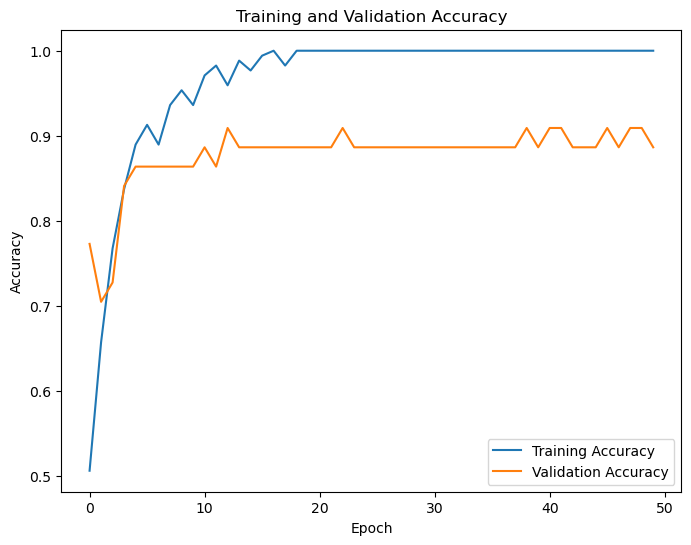

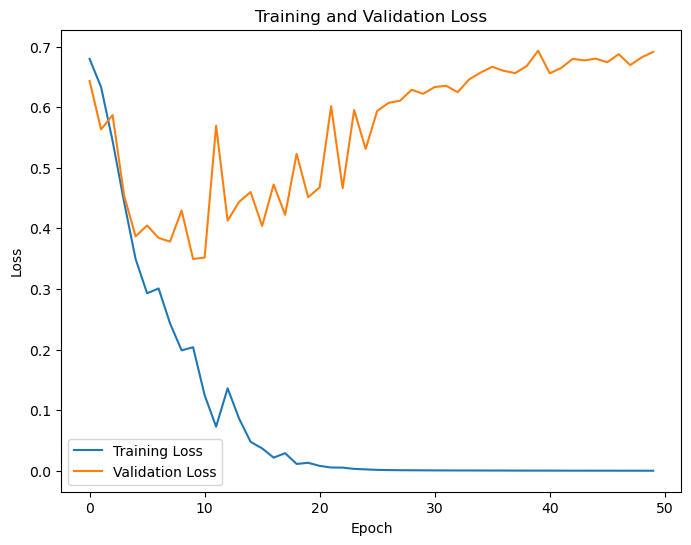

In [6]:
if __name__ == "__main__":
    # Load the annotations from the JSON file
    annotations_file = "annotations.json"
    with open(annotations_file, "r") as json_file:
        annotations = json.load(json_file)

    # Specify the directory where the images are located
    images_dir = "img/not_labeled_stones/"

    # Generate training data from annotations
    roi_size = 64
    negative_samples_per_positive = 1
    train_rois, train_labels = generate_training_data(images_dir, annotations, roi_size, negative_samples_per_positive)

    # Normalize the pixel values to the range [0, 1]
    train_rois = train_rois / 255.0

    # Split the dataset into training and validation sets
    train_rois, val_rois, train_labels, val_labels = train_test_split(train_rois, train_labels, test_size=0.2, random_state=42)

    # Create and compile the model
    input_shape = (roi_size, roi_size, 3)  # Assuming you are using RGB images (3 channels)
    model = create_object_detection_model(input_shape)

import matplotlib.pyplot as plt

# Train the model
history = model.fit(train_rois, train_labels, batch_size=16, epochs=50, validation_data=(val_rois, val_labels))

# Get training and validation accuracy and loss
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

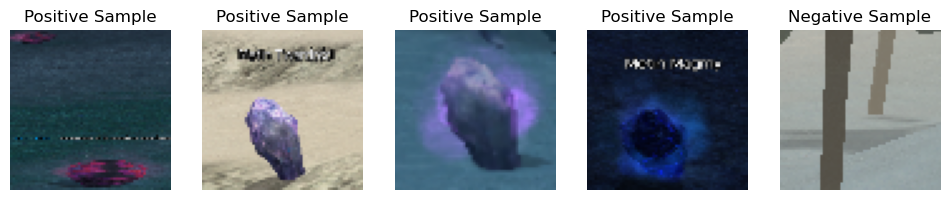

In [7]:
# Choose some random samples to visualize
num_samples_to_visualize = 5
random_indices = np.random.randint(0, len(train_rois), num_samples_to_visualize)
visualize_samples = train_rois[random_indices]
visualize_labels = train_labels[random_indices]

# Visualize the ROIs
plt.figure(figsize=(12, 8))
for i in range(num_samples_to_visualize):
    plt.subplot(1, num_samples_to_visualize, i+1)
    plt.imshow(visualize_samples[i])
    if visualize_labels[i] == 1:
        plt.title('Positive Sample')
    else:
        plt.title('Negative Sample')
    plt.axis('off')
plt.show()

In [8]:
model.save('model_with_handlabels.h5')